In [1398]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib import gridspec
from scipy import stats
import pandas as pd
from pandas import *
import scipy.signal as ss
import re
import matplotlib

In [1399]:
#Formatting

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [1400]:
#R3 GBT Bursts

burst = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

fil = [
'GBT_A.dm348.8.npy',
'GBT_B.dm348.8.npy',
'GBT_C.dm348.8.npy',
'GBT_D.dm348.8.npy',
'GBT_E.dm348.8.npy',
'GBT_F.dm348.8.npy',
'GBT_G.dm348.8.npy',
]

fil_len = [83.333, 83.333, 333.333, 116.666, 83.333, 83.333, 83.333]
rms = [-105, -116.7, -116, -113.8, -107.7, -110, -115.7]


In [1401]:
def spec_burst(burst, fil, fil_len, rms, idx = 1):

    #npy_fil = str('calib_frb/' + str(burst[idx]) + '/' + str(fil[idx]))
    npy_fil = str('npys_for_PAplots/' + str(fil[idx]))
    #temp = re.findall(r'\d+', npy_fil) 
    #res = list(map(int, temp)) 
    #nbin = res[-2]
    #nbin = 4096
    #nchan = res[-1]
    #nchan = 7680
    
    return npy_fil, burst[idx], rms[idx] #burst[idx], npy_fil, fil_len[idx], nbin, nchan

In [1402]:
npy_fil, burst, rm  = spec_burst(burst, fil, fil_len, rms) #burst, npy_fil, fil_len, nbin, nchan  = spec_burst(burst, fil, fil_len)
#npy_fil = "calib_frb/B_686_dm348.8.fits.npy"
print('Burst File: ', npy_fil)
print('Burst: ', burst)
print('Nbin: ', nbin)
print('Nchan: ', nchan)

Burst File:  npys_for_PAplots/GBT_B.dm348.8.npy
Burst:  B
Nbin:  348
Nchan:  8


In [1403]:
# Parameters

#rm = 116.7

cfreq = 800
bw = 400
nchan = nchan
nbin = nbin
subfactor =64
c = 3e8 #light

#tres = fil_len/nbin

fres = bw/nchan
nxmin = 0
nxmax = nbin
nymin = 0
nymax = nchan

## Locate Burst in Timeseries

In [1404]:
def boxcar_kernel(width):
    """Returns the boxcar kernel of given width normalized by
    sqrt(width) for S/N reasons.

    Parameters
    ----------
    width : int
        Width of the boxcar.

    Returns
    -------
    boxcar : array_like
        Boxcar of width `width` normalized by sqrt(width).

    """
    width = int(round(width, 0))
    return np.ones(width, dtype="float32") / np.sqrt(width)


In [1405]:
def find_burst(ts, width_factor=4, min_width=1, max_width=2048):
    """Find burst peak and width using boxcar convolution.

    Parameters
    ----------
    ts : array_like
        Time-series.
    width_factor : int, optional
        Windowing factor for on and off-pulse determination.
    min_width : int, optional
        Minimum width to search from, in number of time samples.
        1 by default.
    max_width : int, optional
        Maximum width to search up to, in number of time samples.
        128 by default.

    Returns
    -------
    peak : int
        Index of the peak of the burst in the time-series.
    width : int
        Width of the burst in number of samples.
    snr : float
        S/N of the burst.

    """
    min_width = int(min_width)
    max_width = int(max_width)

    # do not search widths bigger than timeseries
    widths = list(range(min_width,
                        min(max_width + 1, int((len(ts) - 50) // 6))))

    # envelope finding
    snrs = np.empty_like(widths, dtype=float)
    peaks = np.empty_like(widths, dtype=int)

    # borders for on and off-pulse determination
    outer = 3 * width_factor // 2
    inner = width_factor // 2

    for i in range(len(widths)):
        convolved = ss.convolve(ts, boxcar_kernel(widths[i]))
        peaks[i] = np.nanargmax(convolved)
        # peak should not be on the edge of time-series
        if (peaks[i] > 0.999 * ts.shape[0]) or (peaks[i] < 0.001 * ts.shape[0]):
            snrs[i] = np.nan
        else:
            # get RMS for S/N weighting, as in PRESTO's single_pulse_search.py
            baseline = np.concatenate(
                [
                    convolved[0 : max(0, peaks[i] - 3 * widths[i])],
                    convolved[peaks[i] + 3 * widths[i] :],
                ]
            )

            # cutoff of at least 50 samples is a bit arbitrary, but seems
            # reasonable
            if baseline.shape[0] > 50:
                rms = np.std(baseline)
            else:
                rms = np.nan

            snrs[i] = convolved[peaks[i]] / rms

    best_idx = np.nanargmax(snrs)

    return peaks[best_idx]-widths[best_idx]//2, widths[best_idx], snrs[best_idx]


In [1406]:
def sub_npy(npy_fil, subfactor = 2):
    
    npy = np.load(npy_fil)
    npy_sub = np.flipud(np.nanmean(npy.reshape(-1, subfactor, npy.shape[1]), axis=1))

    return npy, npy_sub[:, :]

198 208


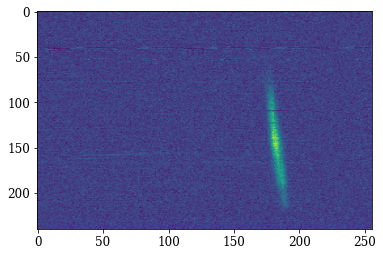

In [1413]:
npy, npy_sub = sub_npy(npy_fil)
peaks, widths, snrs = find_burst(npy.sum(0))
#Define windowing depending on where burst sits in dynspec
window_left = int(peaks - widths)
window_right = int(peaks + widths)

if window_right - window_left <= 100:
    window_right_old = window_right
    window_left_old = window_left
    window_right = window_right_old + 10
    window_left = window_left_old - 10
if window_left <= 0:
    window_left = 0
if window_right >= npy.shape[1]:
    window_right = npy.shape[1]

print(window_right_old, window_right)

plt.imshow(np.flipud(npy_sub), aspect = 'auto')

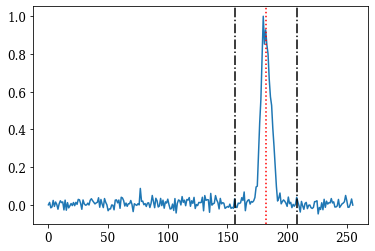

In [1414]:
fig = plt.figure()
plt.plot(npy.sum(0)/np.max(npy.sum(0)))
plt.axvline(peaks, c = 'r', linestyle = 'dotted')
plt.axvline(window_left, c = 'k', linestyle = 'dashdot')
plt.axvline(window_right, c = 'k', linestyle = 'dashdot')
plt.show()

## Read in PA Profile Data

In [1429]:
def read_paprof(burst):    
    
    """
    -------------------
    Vprof - circular polarization
    Lprof - linear polarization
    Iprof - intensity
    -------------------
    """
    
    with open('calib_frb/' + str(burst) + '/pulse.RM116.zoom.paprof', newline='') as fil:
        read = csv.reader(fil, delimiter=' ')
        next(read, None)  # skip the header
        t = []
        I = []
        Q = []
        U = []
        V = []
        P = []
        PAe = []
        
        for row in read:
            t.append(float(row[2]))
            I.append(float(row[3]))
            Q.append(float(row[4]))
            U.append(float(row[5]))
            V.append(float(row[6]))
            P.append(float(row[7]))
            PAe.append(float(row[8]))
            
        t = t[window_left:window_right]
        I = I[window_left:window_right]
        Q = Q[window_left:window_right]
        U = U[window_left:window_right]
        V = V[window_left:window_right]
        P = np.array(P[window_left:window_right])
        P[:np.abs(window_left_old-window_left)] = 0.
        P[-(window_right-window_right_old):] = 0.
        PAe = np.array(PAe[window_left:window_right])
        PAe[:np.abs(window_left_old-window_left)] = 0.
        PAe[-(window_right-window_right_old):] = 0.
            
        freq = np.linspace(cfreq-abs(bw/2),cfreq+abs(bw/2),nchan)
        freq = freq[::-1]
        
        const = rm*(c/((np.mean(freq))*1e6))*(c/((np.mean(freq))*1e6))
        print('Constant: ', const)
        PA = [(i+180) if i < 0 else i for i in P] - (-1* const)
        PAn = np.asarray([np.nan if i <= (-1 * const) else i for i in PA]) #replace 0's with nan's
        PA = [np.nan_to_num(i) for i in PAn] 
        PAen = np.asarray([np.nan if i == 0.0 else i for i in PAe]) #replace 0's with nan's
        PA_err = [1/(i**2) if i != 0 else i for i in PAe]
        PAavg = np.average(PA, weights = PAe)
        PAstd = np.sqrt(np.cov(PA, aweights=PAe))
        PAavg2 = np.average(P, weights = PAe)
        PPA_nimmo = [0.5 * np.arctan(U[i]/Q[i]) for i in range(window_right-window_left)]
        print('PA (adjusted): ', PAavg)
        print('PA (psrchive): ', PAavg2)
        print('PA Error: ', np.sum(1/i if i != 0 else i for i in PAe))
        print('Delta PA (standard deviation): ', PAstd)
        print('PPA (Nimmo et al. 20): ', PPA_nimmo)
        
        # PA offset calculation
        #PAavg = np.mean(PA_nn)
        #print('Offset: ', np.nanmean(PA_n) - PAavg)
        #PA_n = [i - PAavg for i in PA_n]
        #PAavg_u = np.mean(PAe_nn)
        
        # Remove Baseline from Off-Pulse
        #I   = [i - np.nanmean(np.concatenate((np.asarray(I[:window_left]), \
        #                                    np.asarray(I[window_right:])))) for i in  I]
        #Q   = [i - np.nanmean(np.concatenate((np.asarray(Q[:window_left]), \
        #                                    np.asarray(Q[window_right:])))) for i in  Q]
        #U   = [i - np.nanmean(np.concatenate((np.asarray(U[:window_left]), \
        #                                    np.asarray(U[window_right:])))) for i in  U]
        #V   = [i - np.nanmean(np.concatenate((np.asarray(V[:window_left]), \
        #                                    np.asarray(V[window_right:])))) for i in  V]
        
        L = [np.sqrt(pow(Q[i],2)+pow(U[i],2))for i in range(len(V))]

    return t, I, Q, V, P, PA, PAn, PAe, PAen, PA_err, L, PAavg, PPA_nimmo

In [1430]:
# Temporary RFI Manual Mask
npy_sub = np.array(npy_sub)
npy_sub[-58:-50, :] = 0.

Constant:  -16.410937500000003
PA (adjusted):  91.27437177968525
PA (psrchive):  -72.31469072031473
PA Error:  15.229516977848299
Delta PA (standard deviation):  1.7094619699612723
PPA (Nimmo et al. 20):  [-0.18428738358819305, 0.004799261469203629, -0.47818296244582104, -0.60537046185638, 0.5194104601051026, 0.6744784346919053, 0.26909964774322415, 0.12230125281608188, 0.6458678668637969, 0.7204101152437771, -0.13425217620625884, 0.15260225687439935, -0.5769748967952424, -0.062213667601901786, -0.6587588700255128, -0.6695942925924722, 0.19340091156232714, 0.44888423253412524, 0.15809042723468705, -0.2867577892332014, 0.4308646191100992, 0.02087193622115821, -0.729624652410348, 0.7324808756725251, -0.7329243094635552, -0.42835597039001577, 0.6581844528388988, -0.11139275546594164, 0.3074188873064512, 0.34800004451319494, 0.28840891616641307, 0.29730756317141116, 0.2705925294128837, 0.2979317998622716, 0.31124565460718323, 0.29080584217505556, 0.2901601621542811, 0.3250685054776267, 0.2

<ipython-input-1429-7ae9d2da0114>:59: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print('PA Error: ', np.sum(1/i if i != 0 else i for i in PAe))


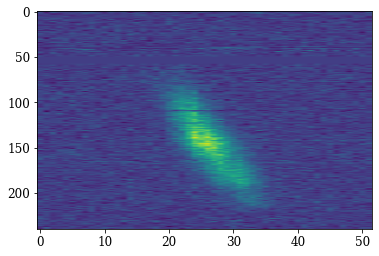

In [1431]:
t, I, Q, V, P, PA, PAn, PAe, PAen, PA_err, L, PAavg, PPA = read_paprof(burst)
fig = plt.figure()
plt.imshow(np.flipud(npy_sub[:, window_left:window_right]), aspect = 'auto')
plt.show()

Text(0.5, 0, 'Time')

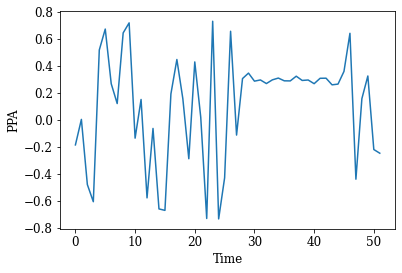

In [1436]:
fig = plt.figure()
t = np.linspace(0, len(PPA), len(PPA))
plt.plot(PPA)
plt.ylabel('PPA')
plt.xlabel('Time')

## Plotting

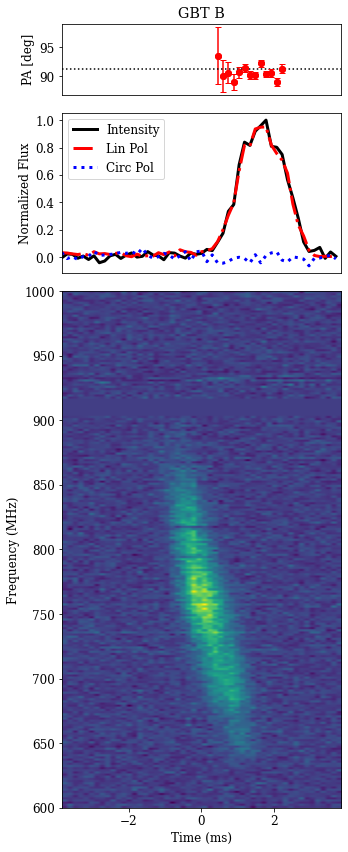

In [1418]:
fig = plt.figure(figsize = (5, 12))

twidth = (2*widths)*tres
specwidth = ((nymax)-(nymin))*fres
spec_lowbound = (nymin)*fres + 600
spec_upbound = spec_lowbound + specwidth

grid = fig.add_gridspec(9, 1)

ax1 = fig.add_subplot(grid[0, 0])
plt.scatter(t, PAn, c = 'r', marker = 'o', linewidths = 1)
plt.errorbar(t, PAn, yerr=PAen, c = 'r', fmt = 'o', capsize = 3)

PAavg_r = str('%s' % float('%.3g' % PAavg))
PAavg_u_r = str('%s' % float('%.1g' % PAavg_u))
plt.hlines(PAavg, xmin = window_left, xmax = window_right, 
            color = 'k', linestyles = 'dotted', \
           label = 'PA: ' + str(PAavg_r) + '(' + str(PAavg_u_r).split('.')[-1] + ')')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xlim(window_left, window_right)
plt.ylabel('PA [deg]')
plt.title('GBT ' + str(burst)) #+ ' | DM 348.8 | RM ' + str(rm))
#plt.legend(loc = 'upper left')

ax2 = fig.add_subplot(grid[1:3, 0])
plt.plot(t, I/np.max(I), c = 'k', linewidth = 3, label = 'Intensity')
plt.plot(t, L/np.max(I), c = 'r', linewidth = 3, linestyle = 'dashdot', label = 'Lin Pol')
plt.plot(t, V/np.max(I), c = 'b', linewidth = 3, linestyle = 'dotted', label = 'Circ Pol')
plt.xlim(window_left, window_right)
#plt.axvline(window_left, c = 'k', linestyle = 'dashdot')
#plt.axvline(window_right, c = 'k', linestyle = 'dashdot')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Normalized Flux')
plt.xlim(window_left, window_right)
plt.legend(loc = 'upper left')

ax3 = fig.add_subplot(grid[-6:, 0])
plt.imshow(np.flipud(npy_sub[:, window_left:window_right]) \
          , extent = [-twidth/2, twidth/2, spec_lowbound, spec_upbound] \
          , interpolation = None, aspect = 'auto')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (MHz)')
#plt.legend(loc = 'upper left')
plt.tight_layout()

fig.savefig(str(burst) + '_PA_plot.png')

plt.show()
